In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_image_data import *
from PIL import Image
from matplotlib import animation, rc
from IPython.display import HTML
from skimage.measure import block_reduce
import time
from IPython.display import clear_output
from kural_core.models import *
from kural_core.data_processing import *

In [4]:
PATH='D:\\Code\\kural_work\\movie_generation\\data\\'
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
nf = img_.n_frames #number of frames

img = []

width = 64
num_angles = 19
center = [230, 245]
rad = 130
edge_param = 0.7
r = rad-edge_param*128//2
crop_cent = []
for i in range(num_angles):
    crop_cent.append((np.int(center[0]+r*np.sin(2*np.pi*i/num_angles)), np.int(center[1]+r*np.cos(2*np.pi*i/num_angles))))
for t, l in crop_cent:
    base_img = []
    for i in range(nf):
        img_.seek(i)
        img.append(np.asarray(list(img_.getdata())).reshape(512,512)[t-width//2:t+width//2,l-width//2:l+width//2])
        base_img.append(img[-1])
    for t in range(2):
        for k in range(0,4):
            if t==0 and k==0: continue
            for i in range(len(base_img)):
                if t==0:
                    img.append(np.rot90(base_img[i],k=k))
                else:
                    img.append(np.rot90(base_img[i].T,k=k))

img = np.stack(img)
img = torch.from_numpy(np.ascontiguousarray(img)).float()
img = (img-img.min().item())/(img.max().item()-img.min().item())
img = img.view(nf*num_angles*8,1,width,width)
# kernel_size = 8
# img = nn.MaxPool2d(kernel_size)(img)
# img = img.view(nf*num_angles*8,width**2//kernel_size**2)
# img = img.cuda()

In [3]:
class CroppedImageDataset(Dataset):
    def __init__(self, img):
        self.img = img
        
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self,idx):
        return self.img[idx].cuda()

In [5]:
class MaxPoolDecoderModel(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.mp = nn.MaxPool2d(kernel_size)
        self.fc1 = nn.Linear(8**2,16**2)
        self.fc2 = nn.Linear(16**2,32**2)
        self.fc3 = nn.Linear(32**2,64**2)
        
    def forward(self, x):
        x = self.mp(x).view(-1,8**2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.clamp(self.fc3(x),0,1)
        return x

In [102]:
ds = CroppedImageDataset(img)
bs = 1000
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, rand_seed=42)
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = MaxPoolDecoderModel(8).cuda()

In [103]:
train_loss = []
val_loss = []
criterion = nn.MSELoss()
per_epoch = len(train_dl)
num_write_out = 3
write_out_point = np.ceil(per_epoch/num_write_out)

In [23]:
from line_profiler import LineProfiler
def do_profile(follow=[]):
    def inner(func):
        def profiled_func(*args,**kwargs):
            try:
                profiler = LineProfiler()
                profiler.add_function(func)
                for f in follow:
                    profiler.add_module(f)
                profiler.enable_by_count()
                return func(*args,**kwargs)
            finally:
                profiler.print_stats()
        return profiled_func
    return inner

In [106]:
# @do_profile(follow=[CroppedImageDataset,MaxPoolDecoderModel])
# def profile_fit():
cycles = 51 #should be odd
epochs = 10
lr_start = 1e-2
lr_end = 1e-4
lr_div = (lr_start/lr_end)**(1/epochs)
time_list = []
print_str = ''
for i in range(cycles):
    ts = time.clock()
    if cycles%2==0:
        lr = lr_start
    else:
        lr = lr_end
    for epoch in range(epochs):
        opt = optim.Adam(model.parameters(), lr=lr)
        if cycles%2==0:
            lr /= lr_div
        else:
            lr *= lr_div
        running_loss = 0.0
        model.train()
        for data in train_dl:
            opt.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred,data.view(data.shape[0],-1))
            loss.backward()
            opt.step()
            running_loss += loss.item()
        train_loss.append(running_loss/len(train_dl))
        
        running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data in val_dl:
                running_loss += criterion(model(data),data.view(data.shape[0],-1)).item()
        val_loss.append(running_loss/len(val_dl))
    tfc = time.clock()-ts
    time_list.append(tfc)
    if print_str: 
        for _ in range(len(print_str)):
            print('\b',end='')
    print_str = f'Cycle: {i+1} ~ Time for cycle: {tfc:.4g}s ~ Remaining: {(cycles-(i+1))*np.mean(time_list):.5g}s'
    print(print_str,end='')
for _ in range(len(print_str)):
            print('\b',end='')
print(f'Done. Spent {int(sum(time_list)//60):d}m {sum(time_list)%60:.2g}s for {cycles} cycles.')
# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\MaxPoolDecoderModel.pth')
#     return model, loss_list

Done. Spent 19m 24s for 51 cycles.


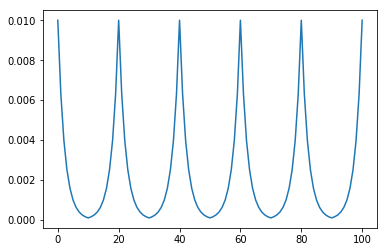

In [101]:
epochs = 10
lr_start = 1e-2
lr_end = 1e-4
lr_div = (lr_start/lr_end)**(1/epochs)
tmp = [lr_start]
for cycles in range(10):
    for _ in range(epochs):
        if cycles%2==0:
            tmp.append(tmp[-1]/lr_div)
        else:
            tmp.append(tmp[-1]*lr_div)
plt.plot(tmp)
# plt.yscale('log')

In [30]:
model, loss_list = profile_fit()

[1, 15] loss: 0.0035492419459236166
[1, 30] loss: 0.003385005227755755
[2, 15] loss: 0.0032041189066755273
[2, 30] loss: 0.0032102067101125917
[3, 15] loss: 0.003186309690742443
[3, 30] loss: 0.0031897875014692545
[1, 15] loss: 0.003211484484684964
[1, 30] loss: 0.0031720687984488904
[2, 15] loss: 0.0030528767383657396
[2, 30] loss: 0.0029930035234428942
[3, 15] loss: 0.0029997823488277695
[3, 30] loss: 0.0030080804329675934
[1, 15] loss: 0.0031407408920737603
[1, 30] loss: 0.0030164400037998953
[2, 15] loss: 0.0029020903748460114
[2, 30] loss: 0.0028943421590762832
[3, 15] loss: 0.0029132902855053544
[3, 30] loss: 0.0028725170025912425
Timer unit: 2.61759e-07 s

Total time: 22.743 s
File: <ipython-input-28-d1458a7934a6>
Function: profile_fit at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @do_profile(follow=[CroppedImageDataset,MaxPoolDecoderModel])
     2                                           def profile_f

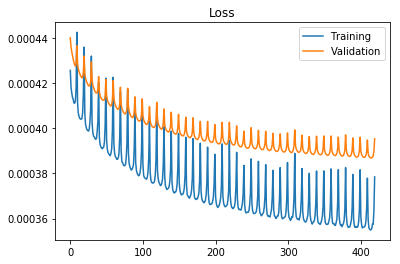

In [126]:
slc = slice(100,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.legend({'Training','Validation'})
plt.title('Loss')
plt.show()

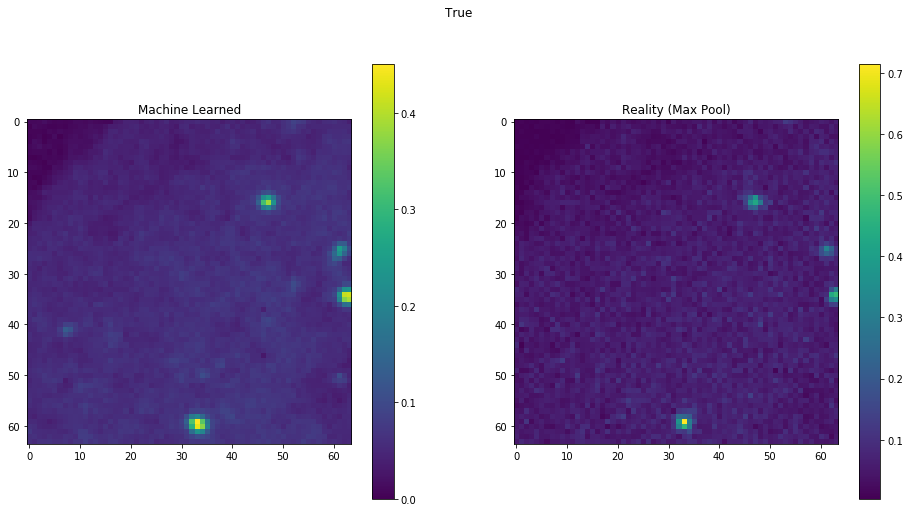

In [123]:
idx = np.random.choice(range(len(ds)))
# while idx%nf < 100:
#     idx = np.random.choice(range(len(ds)))
x = ds[idx]
model.eval()
y_pred = model(x)
# plt.figure()
fig, ax = plt.subplots(1,2,figsize=(16,8))
im0 = ax[0].imshow(y_pred.cpu().data.view(64,64))
ax[0].set_title('Machine Learned')
im1 = ax[1].imshow(x[0].cpu().data)
ax[1].set_title('Reality (Max Pool)')
plt.colorbar(mappable=im0,ax=ax[0])
plt.colorbar(mappable=im1,ax=ax[1])
plt.suptitle(f'{idx in val_idx}')
plt.show()

SyntaxError: invalid syntax (<ipython-input-110-b15584f6632a>, line 1)